In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sb

from matplotlib.colors import hsv_to_rgb
from sklearn.metrics import mean_squared_error as MSE

from scipy.stats import hypergeom
from scipy.stats import norm
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
%config InLineBackend.figure_format = "retina"

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 16
mpl.rcParams["legend.framealpha"] = 0.0
mpl.rcParams["legend.title_fontsize"] = 20
mpl.rcParams["image.cmap"] = "Spectral"
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["savefig.dpi"] = 196

sb.set_palette("Spectral")

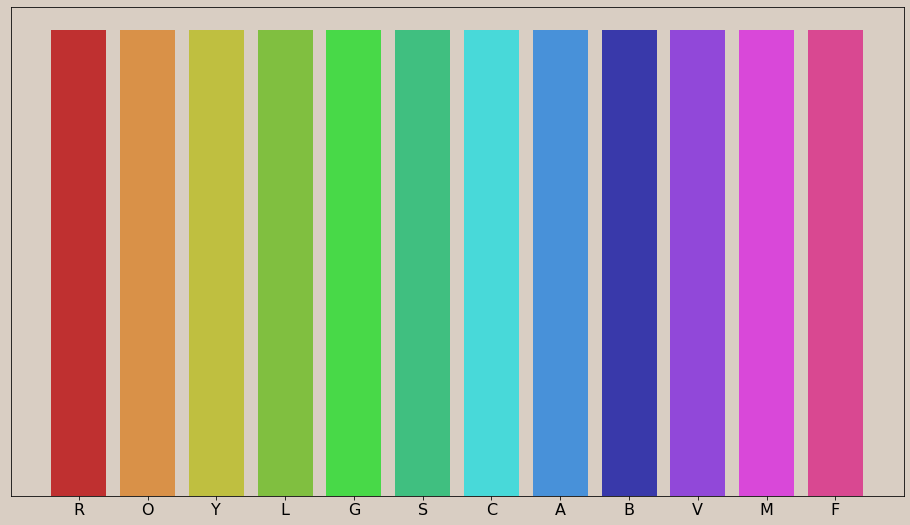

In [3]:
h = 30/360
s = 2/3
v = 0.85
y = 1

R = RED =     hsv_to_rgb([ 0*h, 0.75, 0.75])
O = ORANGE =  hsv_to_rgb([ 1*h, s, v])
Y = YELLOW =  hsv_to_rgb([ 2*h, s, 0.75])
L = LIME =    hsv_to_rgb([ 3*h, s, 0.75])
G = GREEN =   hsv_to_rgb([ 4*h, s, v])
S = SPRING =  hsv_to_rgb([ 5*h, s, 0.75])
C = CYAN =    hsv_to_rgb([ 6*h, s, v])
A = AZURE =   hsv_to_rgb([ 7*h, s, 0.85])
B = BLUE =    hsv_to_rgb([ 8*h, s, 2/3])
V = VIOLET =  hsv_to_rgb([ 9*h, s, v])
M = MAGENTA = hsv_to_rgb([10*h, s, v])
F = FUCHSIA = hsv_to_rgb([11*h, s, v])

FG = AZURE
BG = hsv_to_rgb([1*h, 0.1, 0.85]) # a nice, warm off-white

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.bar(0, y, color=R)
plt.bar(1, y, color=O)
plt.bar(2, y, color=Y)
plt.bar(3, y, color=L)
plt.bar(4, y, color=G)
plt.bar(5, y, color=S)
plt.bar(6, y, color=C)
plt.bar(7, y, color=A)
plt.bar(8, y, color=B)
plt.bar(9, y, color=V)
plt.bar(10, y, color=M)
plt.bar(11, y, color=F)

plt.xticks(range(0, 12), labels=["R", "O", "Y", "L", "G", "S", "C", "A", "B", "V", "M", "F"])
plt.yticks([])

figure.savefig('res/fig/colours.png')
plt.show()

In [4]:
# Month spans from 1 to 12, adding "None" makes it easier than constantly subtracting 1
months = [None, "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

In [5]:
pedestrians = pd.read_csv("datasets/pedestrians.csv", parse_dates=True)

In [6]:
pedestrians.head()

Date  Total_Capel  In_Capel  Out_Capel  Total_Henry  In_Henry  \
0  2015-01-01         3481      1593       1888      19321.0    9520.0   
1  2015-01-02         4437      2150       2287      48178.0   23862.0   
2  2015-01-03         5278      2819       2459      35378.0   17613.0   
3  2015-01-04         4098      2020       2078      29164.0   13832.0   
4  2015-01-05         5757      3162       2595      42606.0   20317.0   

   Out_Henry  Total_Mary  In_Mary  Out_Mary  Total_OConnell  In_OConnell  \
0     9801.0        2257     1188      1069         10761.0       5879.0   
1    24316.0        7077     3339      3738         16964.0       7414.0   
2    17765.0        6139     2786      3353         12856.0       5369.0   
3    15332.0        5322     2323      2999         10722.0       4786.0   
4    22289.0        6670     3133      3537         17099.0       8481.0   

   Out_OConnell  DoY  DoW  Day  Month  
0        4882.0    1    3    1      1  
1        9550.0    2    4    2      1  
2        7487.0    3    5    3      1  
3        5936.0    4    6    4      1  
4        8618.0    5    0    5      1

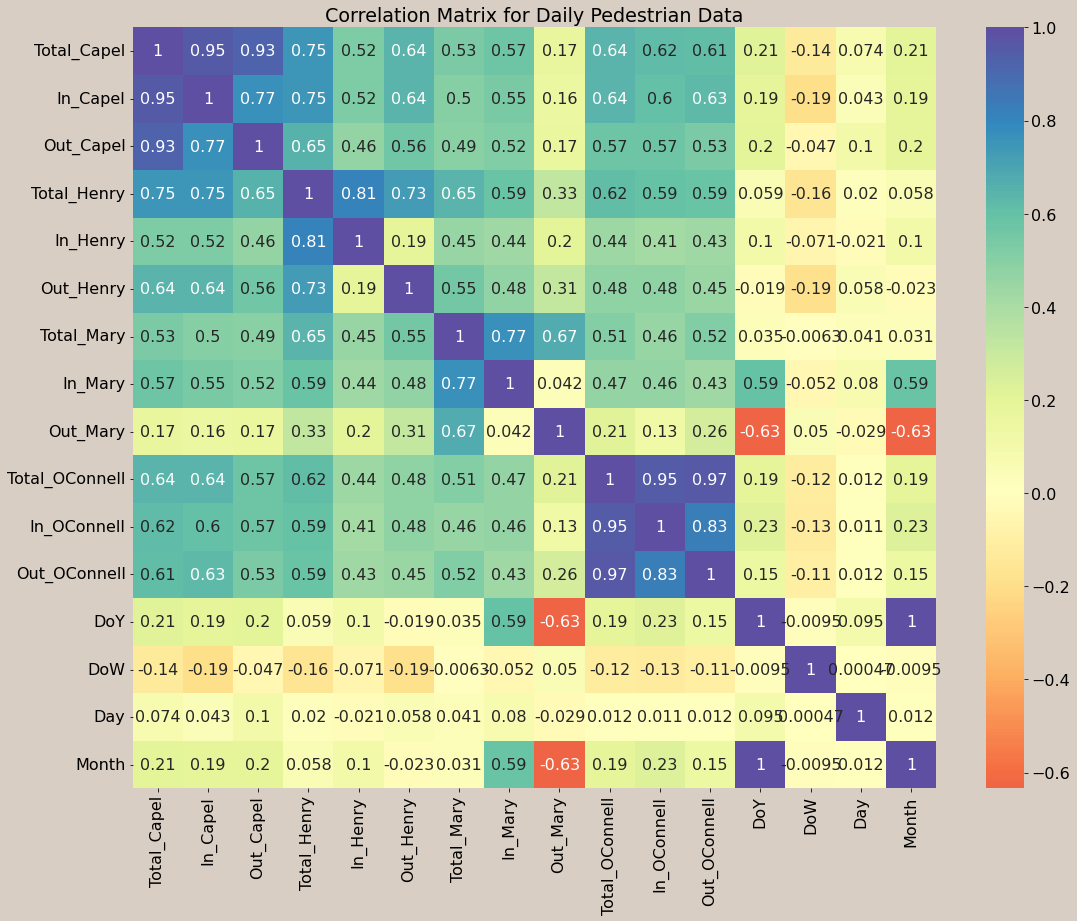

In [7]:
corr = pedestrians.corr()
fig, ax = plt.subplots(figsize = (18, 14))
plt.title(label="Correlation Matrix for Daily Pedestrian Data")
ax.set_facecolor(BG)
fig.patch.set_facecolor(BG)
sb.heatmap(corr, annot=True, center=0, cmap="Spectral")
fig.savefig('res/fig/peds_corr_matrix.png')

In [8]:
np.abs(corr["Total_OConnell"]).sort_values()

Day               0.011806
DoW               0.121972
DoY               0.189949
Month             0.190494
Out_Mary          0.212993
In_Henry          0.443487
In_Mary           0.467402
Out_Henry         0.482807
Total_Mary        0.513213
Out_Capel         0.573812
Total_Henry       0.615819
In_Capel          0.642176
Total_Capel       0.643871
In_OConnell       0.946320
Out_OConnell      0.967373
Total_OConnell    1.000000
Name: Total_OConnell, dtype: float64

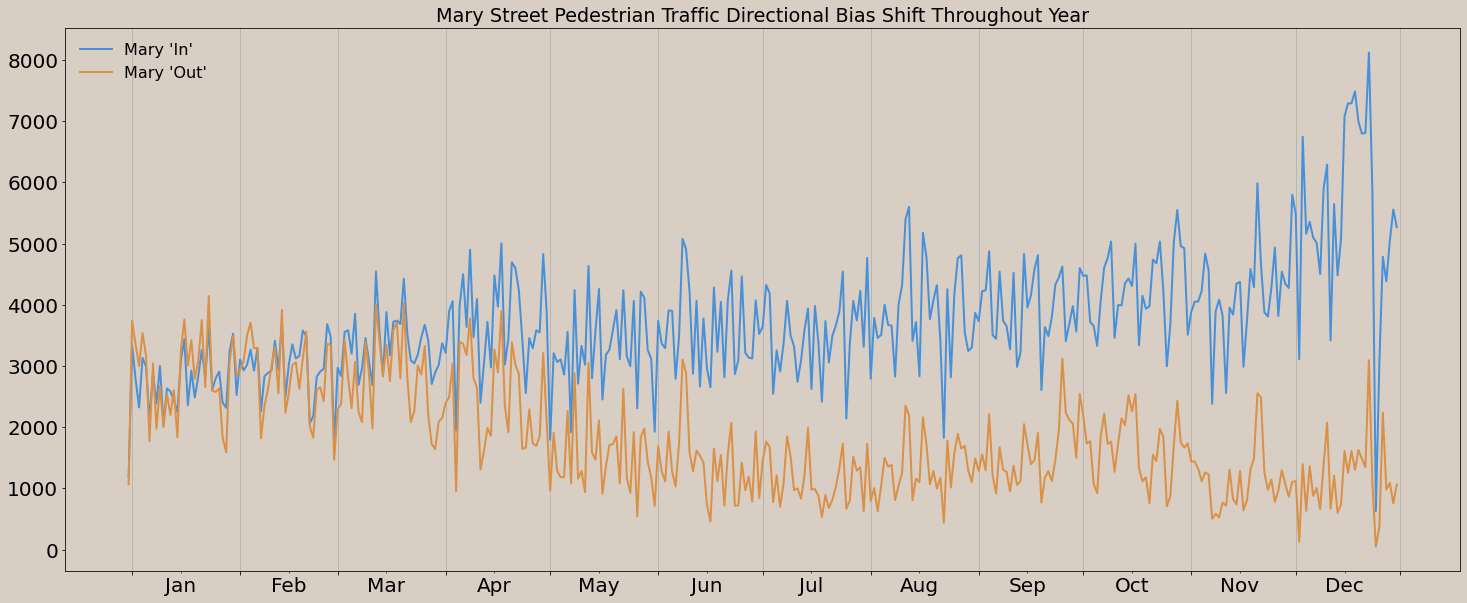

In [9]:
figure = plt.figure(figsize = (25, 10))
ax = plt.axes()
ax.xaxis.grid(True)
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title(label="Mary Street Pedestrian Traffic Directional Bias Shift Throughout Year")
plt.plot(pedestrians["Date"], pedestrians["In_Mary"], label="Mary 'In'", color=FG)
plt.plot(pedestrians["Date"], pedestrians["Out_Mary"], label="Mary 'Out'", color=O)
xticks = pedestrians.loc[(pedestrians["Day"]==1) | (pedestrians["DoY"]==365)]["DoY"].values
ax.xaxis.set_major_formatter(ticker.NullFormatter())
plt.xticks(ticks=xticks)
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks[:-1]+14))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(months[1:]))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.legend(loc="upper left")
plt.savefig("res/fig/mary_direction_throughout_year.png")
plt.show()

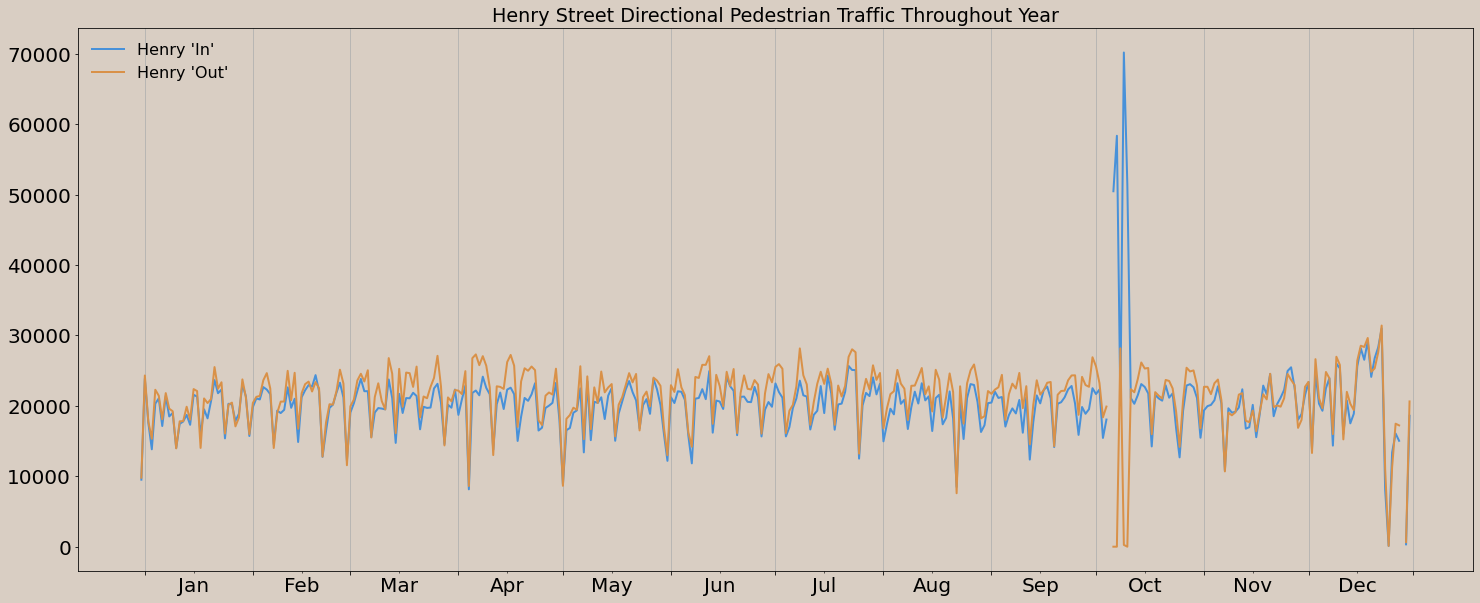

In [10]:
figure = plt.figure(figsize = (25, 10))
ax = plt.axes()
ax.xaxis.grid(True)
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title(label="Henry Street Directional Pedestrian Traffic Throughout Year")
plt.plot(pedestrians["Date"], pedestrians["In_Henry"], label="Henry 'In'", color=FG)
plt.plot(pedestrians["Date"], pedestrians["Out_Henry"], label="Henry 'Out'", color=O)
xticks = pedestrians.loc[(pedestrians["Day"]==1) | (pedestrians["DoY"]==365)]["DoY"].values
ax.xaxis.set_major_formatter(ticker.NullFormatter())
plt.xticks(ticks=xticks)
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks[:-1]+14))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(months[1:]))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.legend(loc="upper left")
plt.savefig("res/fig/henry_direction_throughout_year.png")
plt.show()

In [11]:
pedestrians.sort_values("Out_Henry")[["In_Henry", "Out_Henry"]].head()

In_Henry  Out_Henry
279   50484.0        0.0
283   51429.0        0.0
280   58364.0        0.0
358     110.0      114.0
282   70189.0      255.0

In [12]:
pedestrians["Out_Henry"].replace(0, np.nan, inplace=True)
pedestrians.sort_values("Out_Henry").head(10)

Date  Total_Capel  In_Capel  Out_Capel  Total_Henry  In_Henry  \
358  2015-12-25          996       549        447        224.0     110.0   
282  2015-10-10         6867      3490       3377      70444.0   70189.0   
363  2015-12-30         5224      2546       2678        987.0     334.0   
234  2015-08-23         3863      1844       2019      16076.0    8486.0   
94   2015-04-05         4128      1999       2129      16761.0    8146.0   
121  2015-05-02         4142      2037       2105      17481.0    8836.0   
0    2015-01-01         3481      1593       1888      19321.0    9520.0   
311  2015-11-08         4125      2066       2059      21504.0   10811.0   
357  2015-12-24         5221      2610       2611      19156.0    8116.0   
359  2015-12-26         3637      1750       1887      24676.0   13386.0   

     Out_Henry  Total_Mary  In_Mary  Out_Mary  Total_OConnell  In_OConnell  \
358      114.0         679      631        48          1038.0        588.0   
282      255.0        6800     5034      1766         17180.0       8263.0   
363      653.0        6315     5557       758         11675.0       5722.0   
234     7590.0        2265     1827       438          5366.0       2898.0   
94      8615.0        2901     1948       953         12984.0       6346.0   
121     8645.0        2757     1796       961             NaN          NaN   
0       9801.0        2257     1188      1069         10761.0       5879.0   
311    10693.0        2890     2384       506          9024.0       4726.0   
357    11040.0        6912     5842      1070          9265.0       4470.0   
359    11290.0        3430     3057       373          3326.0       1485.0   

     Out_OConnell  DoY  DoW  Day  Month  
358         450.0  359    4   25     12  
282        8917.0  283    5   10     10  
363        5953.0  364    2   30     12  
234        2468.0  235    6   23      8  
94         6638.0   95    6    5      4  
121           NaN  122    5    2      5  
0          4882.0    1    3    1      1  
311        4298.0  312    6    8     11  
357        4795.0  358    3   24     12  
359        1841.0  360    5   26     12

In [13]:
# Only trying to find missing total values for O'Connell St
pedestrians.drop(["In_OConnell", "Out_OConnell"], axis="columns", inplace=True)

In [14]:
# Henry St only has 5 missing rows so it can be dropped without much significance
pedestrians.dropna(subset=["In_Henry", "Out_Henry", "Total_Henry"], axis="rows", how="any", inplace=True)

In [15]:
pedestrians.isnull().sum()

Date               0
Total_Capel        0
In_Capel           0
Out_Capel          0
Total_Henry        0
In_Henry           0
Out_Henry          0
Total_Mary         0
In_Mary            0
Out_Mary           0
Total_OConnell    94
DoY                0
DoW                0
Day                0
Month              0
dtype: int64

In [16]:
pedestrians.columns

Index(['Date', 'Total_Capel', 'In_Capel', 'Out_Capel', 'Total_Henry',
       'In_Henry', 'Out_Henry', 'Total_Mary', 'In_Mary', 'Out_Mary',
       'Total_OConnell', 'DoY', 'DoW', 'Day', 'Month'],
      dtype='object')

In [17]:
cols = [
    "Total_Capel",
    "Total_Henry",
    "Total_Mary",
]
data = pedestrians[cols]
clustering_scaler = StandardScaler()
data = clustering_scaler.fit_transform(data)
data = pd.DataFrame(data, columns=cols)

db = DBSCAN(
    eps=0.375,
    min_samples=6,
    n_jobs=-1
).fit(data)
labels = db.labels_

pedestrians["Label"] = labels
print(np.count_nonzero(labels+1))

243


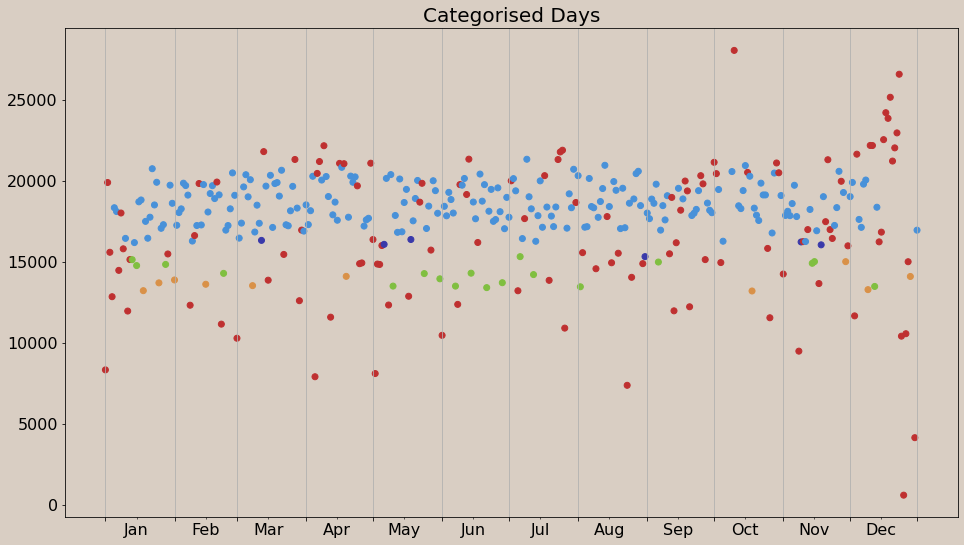

In [18]:
cmap = [R, A, O, L, B]
colours = [cmap[i+1] for i in pedestrians["Label"]]

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
ax.xaxis.grid(True)
figure.patch.set_facecolor(BG)
plt.title(label="Categorised Days", fontsize=20)
avg = np.mean([pedestrians["Total_Capel"], pedestrians["Total_Henry"], pedestrians["Total_Mary"]], axis=0)
plt.scatter(pedestrians["DoY"], avg, c=colours)
xticks = pedestrians.loc[(pedestrians["Day"]==1) | (pedestrians["DoY"]==365)]["DoY"].values
ax.xaxis.set_major_formatter(ticker.NullFormatter())
plt.xticks(ticks=xticks)
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks[:-1]+14))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(months[1:]))
plt.savefig("res/fig/categories.png")
plt.show()

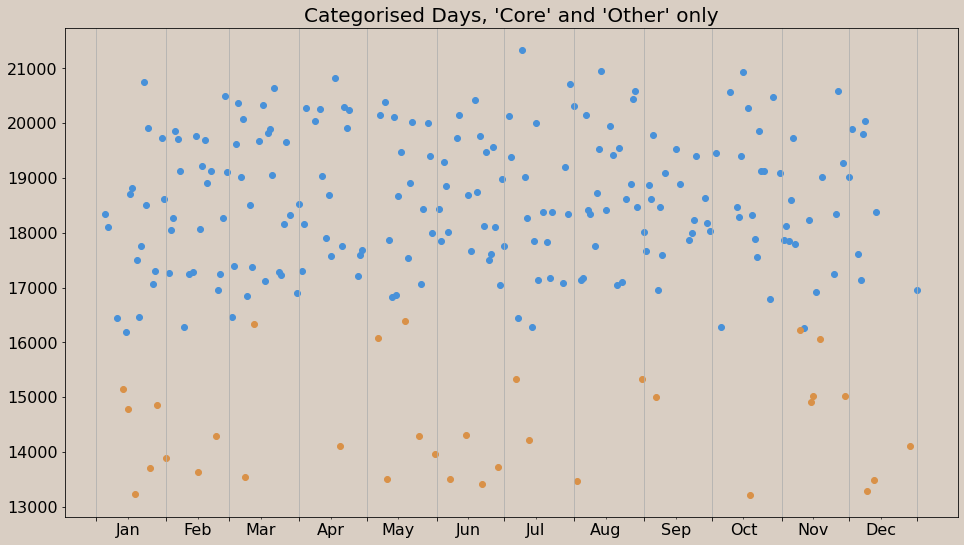

In [19]:
figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
ax.xaxis.grid(True)
figure.patch.set_facecolor(BG)
plt.title(label="Categorised Days, 'Core' and 'Other' only", fontsize=20)
avg_core = np.mean([pedestrians.loc[pedestrians["Label"]==0]["Total_Capel"], pedestrians.loc[pedestrians["Label"]==0]["Total_Henry"], pedestrians.loc[pedestrians["Label"]==0]["Total_Mary"]], axis=0)
avg_other = np.mean([pedestrians.loc[pedestrians["Label"]>0]["Total_Capel"], pedestrians.loc[pedestrians["Label"]>0]["Total_Henry"], pedestrians.loc[pedestrians["Label"]>0]["Total_Mary"]], axis=0)
plt.scatter(pedestrians.loc[pedestrians["Label"]==0]["DoY"], avg_core, color=FG)
plt.scatter(pedestrians.loc[pedestrians["Label"]>0]["DoY"], avg_other, color=O)
xticks = pedestrians.loc[(pedestrians["Day"]==1) | (pedestrians["DoY"]==365)]["DoY"].values
ax.xaxis.set_major_formatter(ticker.NullFormatter())
plt.xticks(ticks=xticks)
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks[:-1]+14))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(months[1:]))
plt.savefig("res/fig/categories_core_other.png")
plt.show()

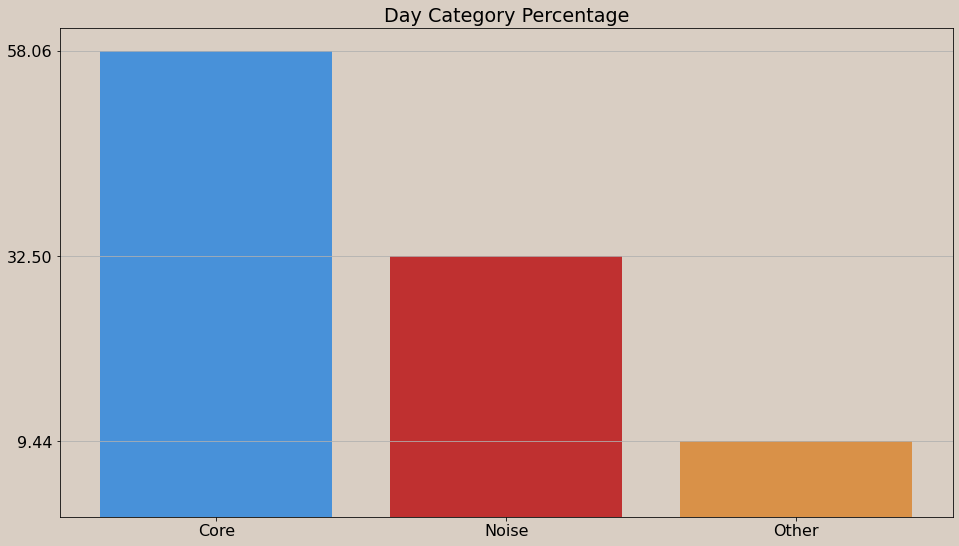

In [20]:
num_days= pedestrians.shape[0]
core_pc = 100*pedestrians.loc[pedestrians["Label"] == 0].shape[0]/num_days
noise_pc = 100*pedestrians.loc[pedestrians["Label"] == -1].shape[0]/num_days
other_pc = 100*pedestrians.loc[pedestrians["Label"] > 0].shape[0]/num_days
figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
ax.yaxis.grid(True)
figure.patch.set_facecolor(BG)
plt.title(label="Day Category Percentage")
plt.bar(0, core_pc, label="Core", color=FG)
plt.bar(1, noise_pc, label="Noise", color=R)
plt.bar(2, other_pc, label="Other", color=O)
plt.yticks([core_pc, noise_pc, other_pc])
plt.xticks([0, 1, 2], ["Core", "Noise", "Other"])
plt.savefig("res/fig/categories_percentage.png")
plt.show()

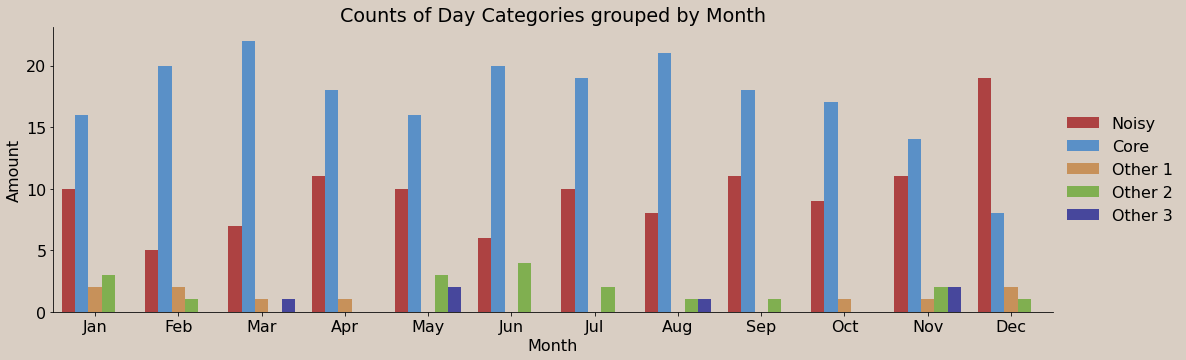

In [21]:
plot = sb.catplot(x="Month", hue="Label", data=pedestrians, aspect=3, kind="count", palette=cmap, legend=False)
ax = plt.gca()
ax.set_facecolor(BG)
plt.title(label="Counts of Day Categories grouped by Month")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(ticks=range(0, 12), labels=months[1:])
plt.legend(labels=["Noisy", "Core", "Other 1", "Other 2", "Other 3"], loc="center left", bbox_to_anchor=(1, 0.5))
figure = plot.fig
figure.patch.set_facecolor(BG)
plt.savefig("res/fig/categories_by_month.png")

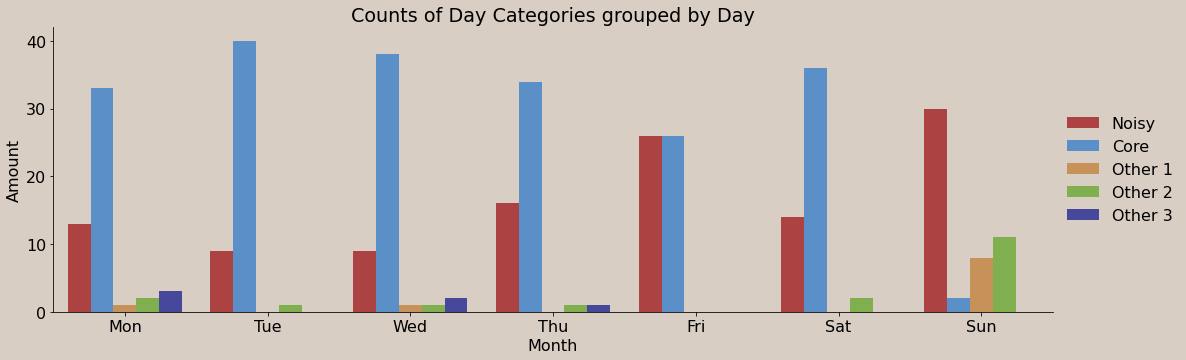

In [22]:
plot = sb.catplot(x="DoW", hue="Label", data=pedestrians, aspect=3, kind="count", palette=cmap, legend=False)
ax = ax = plt.gca()
ax.set_facecolor(BG)
plt.title(label="Counts of Day Categories grouped by Day")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(ticks=range(0, 7), labels=days)
plt.legend(labels=["Noisy", "Core", "Other 1", "Other 2", "Other 3"], loc="center left", bbox_to_anchor=(1, 0.5))
figure = plot.fig
figure.patch.set_facecolor(BG)
plt.savefig("res/fig/categories_by_day.png")

In [23]:
pedestrians.columns

Index(['Date', 'Total_Capel', 'In_Capel', 'Out_Capel', 'Total_Henry',
       'In_Henry', 'Out_Henry', 'Total_Mary', 'In_Mary', 'Out_Mary',
       'Total_OConnell', 'DoY', 'DoW', 'Day', 'Month', 'Label'],
      dtype='object')

In [24]:
# Remvoe noisy data
peds = pedestrians.loc[pedestrians["Label"]>=0]
# Date is non numeric and is effectively captured by DoY, Month, and Day
known = peds[peds.notnull().all(axis="columns")].drop("Date", axis="columns")
known_target = known["Total_OConnell"]
known_data = known.drop("Total_OConnell", axis="columns")
scaler = StandardScaler()
cols_to_scale = [
    "Total_Capel",
    "In_Capel",
    "Out_Capel",
    "Total_Henry",
    "In_Henry",
    "Out_Henry",
    "Total_Mary",
    "In_Mary",
    "Out_Mary",
    "DoY",
    "DoW",
    "Day",
    "Month",
    "Label"
]
known_data = pd.DataFrame(scaler.fit_transform(known_data[cols_to_scale]), columns=cols_to_scale)
known_data["Label"] = known["Label"].values

In [25]:
known_data.head()

Total_Capel  In_Capel  Out_Capel  Total_Henry  In_Henry  Out_Henry  \
0    -0.346151  0.151631  -0.844874     0.004859 -0.112329   0.098250   
1    -0.552350 -0.242283  -0.792741    -0.015555  0.259404  -0.234357   
2    -0.891234 -1.187674  -0.365256    -0.998182 -0.765946  -1.106165   
3    -1.655067 -1.454323  -1.539972    -1.598906 -1.366740  -1.659983   
4    -1.818233 -1.720972  -1.550399    -0.913774 -0.900224  -0.853353   

   Total_Mary   In_Mary  Out_Mary       DoY       DoW       Day     Month  \
0    0.949081 -0.747865  1.675014 -1.455971 -1.390439 -1.266154 -1.368247   
1    0.439363 -0.926510  1.278498 -1.447199 -0.868252 -1.148841 -1.368247   
2   -0.057155 -0.913840  0.730405 -1.412112  1.220497 -0.679586 -1.368247   
3   -0.961855 -1.439639  0.207575 -1.385796 -0.868252 -0.327645 -1.368247   
4   -0.697857 -1.623351  0.652420 -1.377024 -0.346065 -0.210332 -1.368247   

   Label  
0      0  
1      0  
2      0  
3      2  
4      0

In [26]:
pca = PCA()

kdata_pca = pca.fit_transform(known_data)
explained_variance = pca.explained_variance_ratio_

print(explained_variance)

[4.43329073e-01 2.38130789e-01 9.02631068e-02 7.59736659e-02
 5.42174559e-02 3.90376038e-02 2.51802669e-02 1.71782297e-02
 1.11785766e-02 5.50990747e-03 1.32502263e-06 3.27537183e-33
 1.58665704e-33 3.30660696e-34]


In [27]:
print("\tvariance\nexplained\tcumulative\n")
cv = 0
for ev in explained_variance:
    cv += ev
    print(str(round(ev*100, 2)).center(6,), "%\t\t", str(round(cv*100, 2)).center(6,), "%", sep="")

	variance
explained	cumulative

44.33 %		44.33 %
23.81 %		68.15 %
 9.03 %		77.17 %
 7.6  %		84.77 %
 5.42 %		90.19 %
 3.9  %		 94.1 %
 2.52 %		96.61 %
 1.72 %		98.33 %
 1.12 %		99.45 %
 0.55 %		100.0 %
 0.0  %		100.0 %
 0.0  %		100.0 %
 0.0  %		100.0 %
 0.0  %		100.0 %


In [28]:
kdata_pca.shape, known_data.shape

((169, 14), (169, 14))

In [29]:
def model_component_stats(comps, target):
    print("#    Linear Regression                            Random Forest")
    print("#   Train %       Test %    Num Components    Train %        Test %")
    num_comps = comps.shape[1]
    for c in range(0, num_comps):
        rand_mag = 10
        lr_train_accs = np.zeros(rand_mag)
        lr_test_accs = np.zeros(rand_mag)
        rf_train_accs = np.zeros(rand_mag)
        rf_test_accs = np.zeros(rand_mag)
        for r in range(0, rand_mag):
            train_data, test_data, train_target, test_target = train_test_split(
                comps[:, :c+1],
                target,
                test_size=0.25,
                random_state=r
            )
            lr_model = LinearRegression(n_jobs=-1)
            lr_model.fit(train_data, train_target)
            lr_train_accs[r] = lr_model.score(train_data, train_target)
            lr_test_accs[r] = lr_model.score(test_data, test_target)
            rf_model = RandomForestRegressor(n_jobs=-1, random_state=1)
            rf_model.fit(train_data, train_target)
            rf_train_accs[r] = rf_model.score(train_data, train_target)
            rf_test_accs[r] = rf_model.score(test_data, test_target)
        lr_train_mean = str(round(np.mean(lr_train_accs)*100, 3)).center(7)
        lr_test_mean = str(round(np.mean(lr_test_accs)*100, 3)).center(7)
        rf_train_mean = str(round(np.mean(rf_train_accs)*100, 3)).center(7)
        rf_test_mean = str(round(np.mean(rf_test_accs)*100, 3)).center(7)
        print("# ", lr_train_mean, " %     ", lr_test_mean, " %        C: ", str(c+1).rjust(2, "0"), "       ", lr_train_mean, " %     ", lr_test_mean, " %", sep="")

In [30]:
def rfe_acc(data, target, model):
    rfe = RFE(model)
    rfe = rfe.fit(data, target)
    print(rfe.score(data, target))
    print(rfe.support_)
    print(rfe.ranking_)
    print(rfe.get_feature_names_out())
    return data.loc[:, rfe.support_]

In [31]:
run_model_component_stats = False
if run_model_component_stats:
    model_component_stats(kdata_pca, known_target)
else:
    print("#    Linear Regression                            Random Forest")
    print("#   Train %       Test %    Num Components    Train %        Test %")
    print("#  42.671 %      35.297 %        C: 01        42.671 %      35.297 %")
    print("#  43.062 %      34.135 %        C: 02        43.062 %      34.135 %")
    print("#  43.166 %      33.671 %        C: 03        43.166 %      33.671 %")
    print("#  44.321 %      33.842 %        C: 04        44.321 %      33.842 %")
    print("#  44.849 %      34.165 %        C: 05        44.849 %      34.165 %")
    print("#  45.501 %      33.681 %        C: 06        45.501 %      33.681 %")
    print("#  45.604 %      32.767 %        C: 07        45.604 %      32.767 %")
    print("#  45.93  %      33.433 %        C: 08        45.93  %      33.433 %")
    print("#  46.258 %      31.568 %        C: 09        46.258 %      31.568 %")
    print("#  46.922 %      31.838 %        C: 10        46.922 %      31.838 %")
    print("#  47.515 %      32.575 %        C: 11        47.515 %      32.575 %")
    print("#  47.515 %      32.575 %        C: 12        47.515 %      32.575 %")
    print("#  47.515 %      32.575 %        C: 13        47.515 %      32.575 %")
    print("#  47.515 %      32.575 %        C: 14        47.515 %      32.575 %")

#    Linear Regression                            Random Forest
#   Train %       Test %    Num Components    Train %        Test %
#  42.671 %      35.297 %        C: 01        42.671 %      35.297 %
#  43.062 %      34.135 %        C: 02        43.062 %      34.135 %
#  43.166 %      33.671 %        C: 03        43.166 %      33.671 %
#  44.321 %      33.842 %        C: 04        44.321 %      33.842 %
#  44.849 %      34.165 %        C: 05        44.849 %      34.165 %
#  45.501 %      33.681 %        C: 06        45.501 %      33.681 %
#  45.604 %      32.767 %        C: 07        45.604 %      32.767 %
#  45.93  %      33.433 %        C: 08        45.93  %      33.433 %
#  46.258 %      31.568 %        C: 09        46.258 %      31.568 %
#  46.922 %      31.838 %        C: 10        46.922 %      31.838 %
#  47.515 %      32.575 %        C: 11        47.515 %      32.575 %
#  47.515 %      32.575 %        C: 12        47.515 %      32.575 %
#  47.515 %      32.575 %        C: 13  

In [32]:
num_comps = 8
train_data, test_data, train_target, test_target = train_test_split(
    kdata_pca[:, :num_comps],
    known_target,
    test_size = 0.25,
    random_state=20
)

In [33]:
lr_pca_model = LinearRegression(n_jobs=-1)
lr_pca_model.fit(train_data, train_target)
lr_pca_pred = lr_pca_model.predict(kdata_pca[:, :num_comps])

In [34]:
rf_pca_model = RandomForestRegressor(n_jobs=-1, random_state=24)
rf_pca_model.fit(train_data, train_target)
rf_pca_pred = rf_pca_model.predict(kdata_pca[:, :num_comps])

In [35]:
lr_rfe_model = LinearRegression(n_jobs=-1)
lr_rfe_data = rfe_acc(known_data, known_target, lr_rfe_model)
train_data, test_data, train_target, test_target = train_test_split(
    lr_rfe_data,
    known_target,
    test_size=0.25,
    random_state=20
)
lr_rfe_model.fit(train_data, train_target)
lr_rfe_pred = lr_rfe_model.predict(lr_rfe_data)

0.4554655672419343
[False  True False  True False False False False  True  True  True  True
  True False]
[3 1 7 1 5 6 2 8 1 1 1 1 1 4]
['In_Capel' 'Total_Henry' 'Out_Mary' 'DoY' 'DoW' 'Day' 'Month']


In [36]:
rf_rfe_model = RandomForestRegressor(n_jobs=-1, random_state=24)
rf_rfe_data = rfe_acc(known_data, known_target, rf_rfe_model)
train_data, test_data, train_target, test_target = train_test_split(
    rf_rfe_data,
    known_target,
    test_size=0.25,
    random_state=20
)
rf_rfe_model.fit(train_data, train_target)
rf_rfe_pred = rf_rfe_model.predict(rf_rfe_data)

0.9160651610543113
[ True  True False  True  True False False  True False  True False  True
 False False]
[1 1 6 1 1 3 2 1 5 1 4 1 7 8]
['Total_Capel' 'In_Capel' 'Total_Henry' 'In_Henry' 'In_Mary' 'DoY' 'Day']


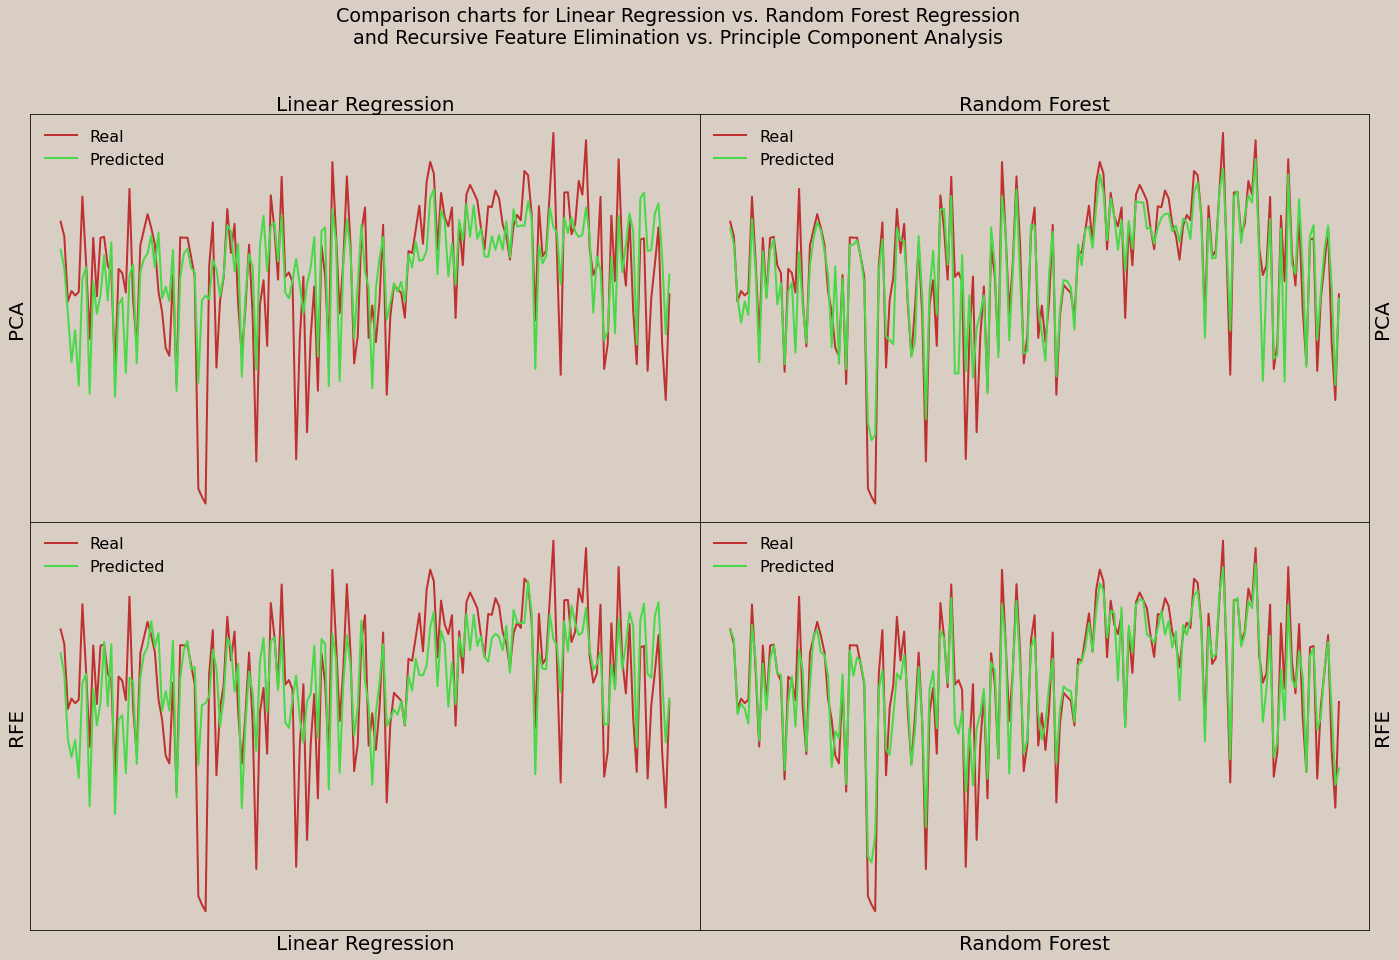

In [37]:
figure, ax = plt.subplots(2, 2, figsize = (24, 15))
figure.patch.set_facecolor(BG)
x = range(0, len(lr_pca_pred))

def splot(pred, px, py, model_name, dim_red_alg):
    ax[px, py].set_facecolor(BG)
    ax[px, py].set_xlabel(model_name, fontsize=20)
    ax[px, py].set_ylabel(dim_red_alg, fontsize=20)
    if px == 0:
        ax[px, py].xaxis.set_label_position("top")
    if py == 1:
        ax[px, py].yaxis.set_label_position("right")
    ax[px, py].plot(x, known_target, label="Real", color=R)
    ax[px, py].plot(x, pred, label="Predicted", color=G)
    plt.subplots_adjust(wspace=0, hspace=0)
    ax[px, py].legend(loc="upper left")
    ax[px, py].tick_params(
        axis = 'both',
        which = 'both',
        labeltop = False,
        labelbottom = False,
        labelleft = False,
        labelright = False,
        top = False,
        bottom = False,
        left = False,
        right = False
    )
figure.suptitle("Comparison charts for Linear Regression vs. Random Forest Regression\nand Recursive Feature Elimination vs. Principle Component Analysis")
splot(lr_pca_pred, 0, 0, "Linear Regression", "PCA")
splot(rf_pca_pred, 0, 1, "Random Forest", "PCA")
splot(lr_rfe_pred, 1, 0, "Linear Regression", "RFE")
splot(rf_rfe_pred, 1, 1, "Random Forest", "RFE")
figure.savefig('res/fig/lr_v_fr_pca_v_rfe_comparison.png')
plt.show()

In [38]:
print("MSE for each model and dimensionality reduction strategy")
print("RF RFE   ", MSE(known_target, rf_rfe_pred))
print("RF PCA   ", MSE(known_target, rf_pca_pred))
print("LR RFE   ", MSE(known_target, lr_rfe_pred))
print("LR PCA   ", MSE(known_target, lr_pca_pred))

MSE for each model and dimensionality reduction strategy
RF RFE    1421026.251510651
RF PCA    1886610.35424497
LR RFE    5483845.920718418
LR PCA    5602364.358822286


In [39]:
def gridsearch_random_forest(params, data, target, folds=None):
    rf_model = RandomForestRegressor(n_jobs=-1)
    model_cv = GridSearchCV(
        estimator = rf_model,
        param_grid = params,
        scoring= 'neg_mean_absolute_error',
        return_train_score=True,
        cv=folds,
        verbose = 1,
    )
    fit = model_cv.fit(data, target)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    return cv_results

In [40]:
def gsrf_primary():
    params = {
        'n_estimators': [100, 250, 500],
        'max_depth'   : [None, 4, 6, 8],
        "min_samples_split":[2, 4, 6],
        'criterion'   : ["squared_error", "absolute_error", "poisson"],
        "random_state": [24]
    }
    cv_results = gridsearch_random_forest(params, rf_rfe_data, known_target)
    cv_results.to_csv("datasets/random_forest_grid_search_cv_stats_1.csv", index=False)
#gsrf_primary()
##Fitting 5 folds for each of 108 candidates, totalling 540 fits

In [41]:
cv_results = pd.read_csv("datasets/random_forest_grid_search_cv_stats_1.csv")

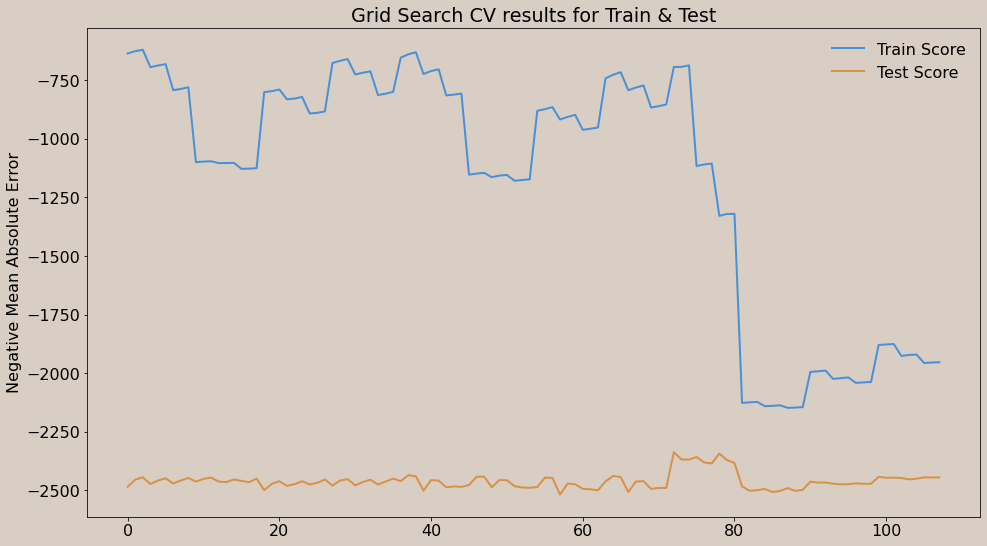

In [42]:
plt.show()

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title("Grid Search CV results for Train & Test")
plt.plot(cv_results['mean_train_score'], label="Train Score", color=FG)
plt.plot(cv_results['mean_test_score'], label = "Test Score", color=O)
plt.legend(loc='upper right')
plt.ylabel('Negative Mean Absolute Error')
figure.savefig('res/fig/random_forest_grid_search_nmae_initial.png')
plt.show()

In [43]:
gsrf_cols = [
    'param_criterion', 'param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'param_random_state',
    'mean_test_score', 'mean_train_score', 'rank_test_score', 'std_test_score', 'std_train_score'
]

In [44]:
cv_results[gsrf_cols].sort_values("rank_test_score").head(20)

param_criterion  param_max_depth  param_min_samples_split  \
72          poisson              NaN                        2   
78          poisson              NaN                        6   
75          poisson              NaN                        4   
73          poisson              NaN                        2   
74          poisson              NaN                        2   
79          poisson              NaN                        6   
76          poisson              NaN                        4   
80          poisson              NaN                        6   
77          poisson              NaN                        4   
37   absolute_error              NaN                        2   
64   absolute_error              8.0                        2   
38   absolute_error              NaN                        2   
47   absolute_error              4.0                        2   
99          poisson              8.0                        2   
46   absolute_error              4.0                        2   
65   absolute_error              8.0                        2   
2     squared_error              NaN                        2   
105         poisson              8.0                        6   
107         poisson              8.0                        6   
106         poisson              8.0                        6   

     param_n_estimators  param_random_state  mean_test_score  \
72                  100                  24     -2337.154733   
78                  100                  24     -2342.700607   
75                  100                  24     -2357.701773   
73                  250                  24     -2368.004614   
74                  500                  24     -2368.715765   
79                  250                  24     -2370.740620   
76                  250                  24     -2380.762584   
80                  500                  24     -2382.666881   
77                  500                  24     -2385.011710   
37                  250                  24     -2435.133613   
64                  250                  24     -2438.256592   
38                  500                  24     -2440.266163   
47                  500                  24     -2441.332693   
99                  100                  24     -2441.895276   
46                  250                  24     -2442.101832   
65                  500                  24     -2443.443327   
2                   500                  24     -2444.117845   
105                 100                  24     -2444.356615   
107                 500                  24     -2444.465576   
106                 250                  24     -2445.126343   

     mean_train_score  rank_test_score  std_test_score  std_train_score  
72        -693.278508                1      772.282151        63.683949  
78       -1328.635879                2      745.536868        99.678511  
75       -1115.978509                3      757.942339        80.116840  
73        -692.949111                4      752.027577        59.299370  
74        -686.386157                5      740.949976        57.512505  
79       -1320.573758                6      735.462124       102.068315  
76       -1109.141708                7      750.143952        82.647062  
80       -1319.885448                8      725.419889       103.103284  
77       -1105.632565                9      738.112137        80.839205  
37        -639.258842               10     1033.280160        56.007552  
64        -726.277271               11     1039.607712        69.350092  
38        -630.486741               12     1032.054995        57.696484  
47       -1145.054500               13      993.059039       103.292906  
99       -1879.399532               14      549.160080        82.959029  
46       -1148.155582               15      994.128090       104.294941  
65        -715.727133               16     1034.515064        68.031999  
2         -619.964565              

In [45]:
def gsrf_secondary():
    params = {
        'n_estimators': [100],
        'max_depth'   : [None],
        "min_samples_split":[2, 3, 4, 5, 6, 7, 8],
        'criterion'   : ["poisson"],
        "random_state": [24]
    }
    cv_results = gridsearch_random_forest(params, rf_rfe_data, known_target)
    cv_results.to_csv("datasets/random_forest_grid_search_cv_stats_2.csv", index=False)
#gsrf_secondary()
##Fitting 5 folds for each of 15 candidates, totalling 75 fits

In [46]:
cv_results = pd.read_csv("datasets/random_forest_grid_search_cv_stats_2.csv")
cv_results[gsrf_cols].sort_values("rank_test_score")

param_criterion  param_max_depth  param_min_samples_split  \
1         poisson              NaN                        3   
0         poisson              NaN                        2   
4         poisson              NaN                        6   
3         poisson              NaN                        5   
6         poisson              NaN                        8   
5         poisson              NaN                        7   
2         poisson              NaN                        4   

   param_n_estimators  param_random_state  mean_test_score  mean_train_score  \
1                 100                  24     -2335.546830       -948.404175   
0                 100                  24     -2337.154733       -693.278508   
4                 100                  24     -2342.700607      -1328.635879   
3                 100                  24     -2345.332710      -1241.468201   
6                 100                  24     -2347.788997      -1435.653856   
5                 100                  24     -2349.644926      -1395.345552   
2                 100                  24     -2357.701773      -1115.978509   

   rank_test_score  std_test_score  std_train_score  
1                1      763.322837        72.008528  
0                2      772.282151        63.683949  
4                3      745.536868        99.678511  
3                4      750.528663        88.550015  
6                5      729.325640       120.599786  
5                6      733.071645       114.072670  
2                7      757.942339        80.116840

In [47]:
def gsrf_tertiary():
    params = {
        'n_estimators': np.arange(50, 751, 50),
        'max_depth'   : [None],
        "min_samples_split":[3],
        'criterion'   : ["poisson"],
        "random_state": [24]
    }
    cv_results = gridsearch_random_forest(params, rf_rfe_data, known_target)
    cv_results.to_csv("datasets/random_forest_grid_search_cv_stats_3.csv", index=False)
#gsrf_tertiary()
##Fitting 5 folds for each of 14 candidates, totalling 70 fits

In [48]:
cv_results = pd.read_csv("datasets/random_forest_grid_search_cv_stats_3.csv")
cv_results[gsrf_cols].sort_values("rank_test_score")

param_criterion  param_max_depth  param_min_samples_split  \
1          poisson              NaN                        3   
2          poisson              NaN                        3   
3          poisson              NaN                        3   
0          poisson              NaN                        3   
4          poisson              NaN                        3   
6          poisson              NaN                        3   
8          poisson              NaN                        3   
7          poisson              NaN                        3   
5          poisson              NaN                        3   
10         poisson              NaN                        3   
14         poisson              NaN                        3   
9          poisson              NaN                        3   
13         poisson              NaN                        3   
11         poisson              NaN                        3   
12         poisson              NaN                        3   

    param_n_estimators  param_random_state  mean_test_score  mean_train_score  \
1                  100                  24     -2335.546830       -948.404175   
2                  150                  24     -2350.228246       -949.725691   
3                  200                  24     -2357.389223       -949.547416   
0                   50                  24     -2369.215327       -960.495577   
4                  250                  24     -2372.122468       -940.946442   
6                  350                  24     -2373.218493       -939.224807   
8                  450                  24     -2374.830852       -937.030945   
7                  400                  24     -2375.041661       -936.892104   
5                  300                  24     -2375.076561       -940.075633   
10                 550                  24     -2377.848843       -936.815943   
14                 750                  24     -2378.606068       -937.415370   
9                  500                  24     -2381.050652       -935.975353   
13                 700                  24     -2381.202870       -938.226656   
11                 600                  24     -2382.096907       -937.230918   
12                 650                  24     -2382.402145       -937.071959   

    rank_test_score  std_test_score  std_train_score  
1                 1      763.322837        72.008528  
2                 2      753.841906        71.351747  
3                 3      753.218876        71.232162  
0                 4      772.352714        77.816772  
4                 5      750.458258        72.676240  
6                 6      744.357979        74.188986  
8                 7      743.371892        74.576349  
7                 8      741.859933        74.177602  
5                 9      743.783933        74.945721  
10               10      742.461216        73.419228  
14               11      743.413034        73.090961  
9                12      741.134424        73.786344  
13               13      740.851266        72.954486  
11               14      741.043761        72.544566  
12               15      737.573609        72.936025

In [49]:
best_result = cv_results[gsrf_cols].sort_values("rank_test_score").iloc[0]
best_result

param_criterion               poisson
param_max_depth                   NaN
param_min_samples_split             3
param_n_estimators                100
param_random_state                 24
mean_test_score           -2335.54683
mean_train_score          -948.404175
rank_test_score                     1
std_test_score             763.322837
std_train_score             72.008528
Name: 1, dtype: object

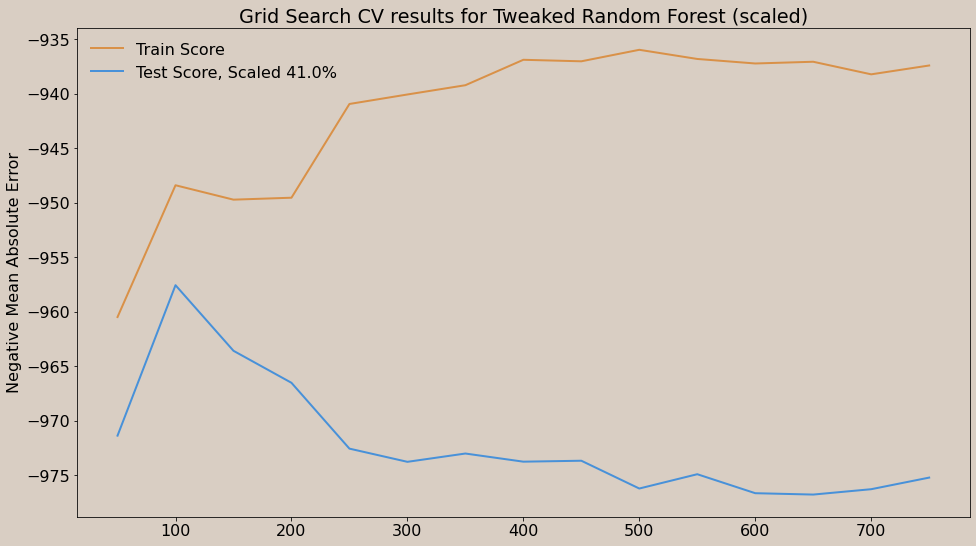

In [50]:
figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title("Grid Search CV results for Tweaked Random Forest (scaled)")
factor = round(best_result.mean_train_score / best_result.mean_test_score, 2)
plt.plot(cv_results["param_n_estimators"], cv_results['mean_train_score'], label = "Train Score", color=O)
plt.plot(cv_results["param_n_estimators"], cv_results['mean_test_score']*factor, label="Test Score, Scaled "+str(factor*100)+"%", color=FG)
plt.legend(loc='upper left')
plt.ylabel('Negative Mean Absolute Error')
figure.savefig('res/fig/random_forest_grid_search_nmae_final_scaled.png')
plt.show()

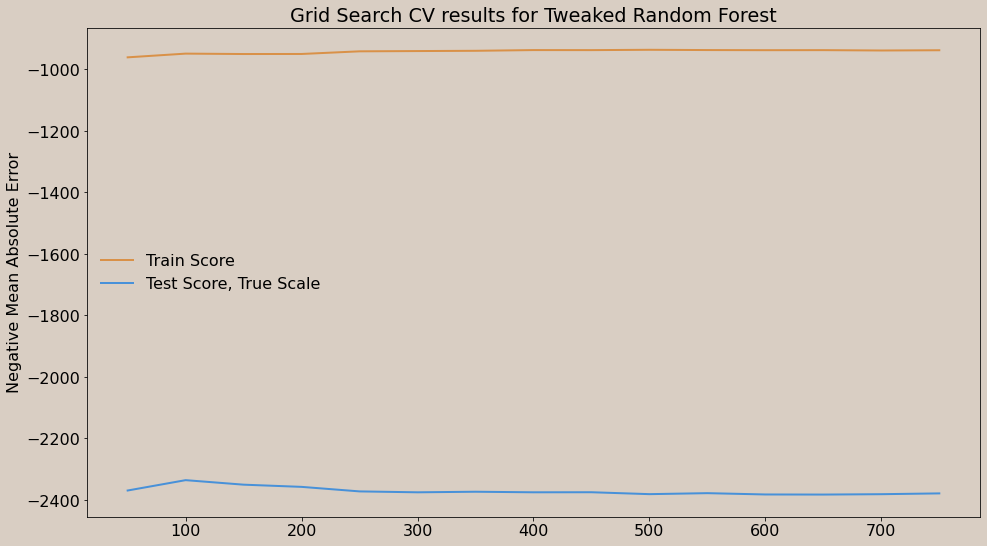

In [51]:
figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title("Grid Search CV results for Tweaked Random Forest")
plt.plot(cv_results["param_n_estimators"], cv_results['mean_train_score'], label = "Train Score", color=O)
plt.plot(cv_results["param_n_estimators"], cv_results['mean_test_score'], label="Test Score, True Scale", color=FG)
plt.legend(loc='center left')
plt.ylabel('Negative Mean Absolute Error')
figure.savefig('res/fig/random_forest_grid_search_nmae_final.png')
plt.show()

0.8215642905521511
[ True  True  True False  True  True  True False False  True False False
 False False]
[1 1 1 4 1 1 1 3 2 1 6 5 7 8]
['Total_Capel' 'In_Capel' 'Out_Capel' 'In_Henry' 'Out_Henry' 'Total_Mary'
 'DoY']


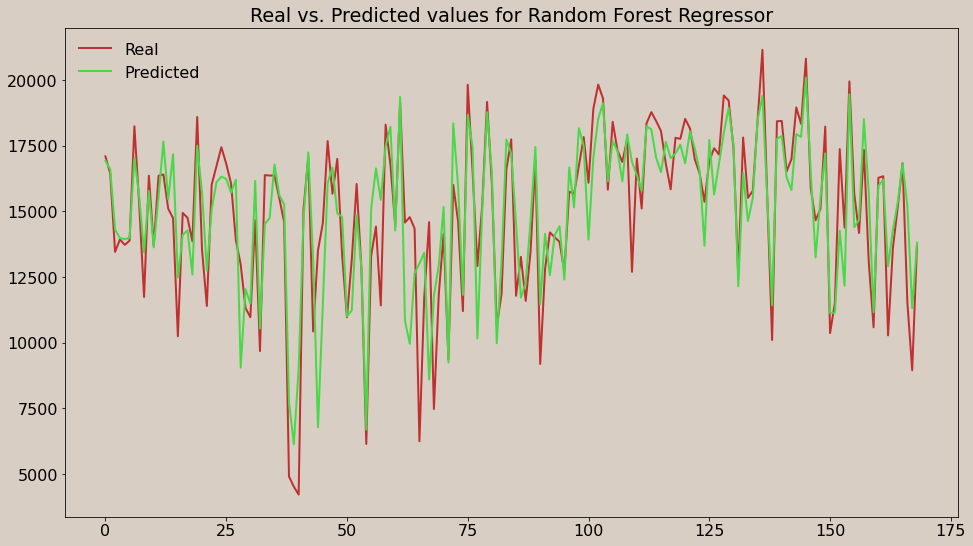

In [52]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 3,
    max_depth = None,
    criterion = "poisson",
    random_state = 24,
    n_jobs = -1
)
data = rfe_acc(known_data, known_target, model)
rfe_cols = data.columns

train_data, test_data, train_target, test_target = train_test_split(
    data,
    known_target,
    test_size=0.25,
    random_state=20
)
model.fit(train_data, train_target)
pred = model.predict(data)

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title(label="Real vs. Predicted values for Random Forest Regressor")
x = range(0, len(pred))
plt.plot(x, known_target, label="Real", color=R)
plt.plot(x, pred, label="Predicted", color=G)
plt.legend(loc="upper left")
figure.savefig('res/fig/tweaked_random_forest_real_vs_pred.png')
plt.show()

In [53]:
unknown = pedestrians.loc[pedestrians["Total_OConnell"].isnull()]
# retrain model with all known data
model.fit(data, known_target)
data = pd.DataFrame(scaler.transform(unknown[cols_to_scale]), columns=cols_to_scale)
data = data[rfe_cols]
real = known["Total_OConnell"]
pred = model.predict(data)

In [54]:
pred = np.round(pred).astype(int)

In [55]:
data["Predicted"] = pred
data["DoY"] = unknown["DoY"].values
data

Total_Capel  In_Capel  Out_Capel  In_Henry  Out_Henry  Total_Mary  DoY  \
0     -0.891234 -0.399848  -1.268884  0.875996   0.087585   -0.215554   91   
1      0.166657  0.669778  -0.445192  0.472175   1.477264    1.101388   98   
2      1.172549  2.063624  -0.094167  1.778422   1.983679    2.987955   99   
3      0.586227  1.039450  -0.055937  0.990527   1.443687    0.549024  100   
4      0.231206  0.730380  -0.389584  0.544251   0.234137    1.021173  101   
..          ...       ...        ...       ...        ...         ...  ...   
89     1.527570  0.812193   2.029359  0.147341   1.043927   -0.823764  253   
90    -2.807988 -1.884597  -3.281194 -3.056074  -2.391955   -0.577027  343   
91     0.548573  0.948547  -0.024657  2.702076   1.950498    1.579629  344   
92     1.920245  1.863638   1.584496  2.357989   1.492275    2.670142  345   
93    -1.486521 -0.199861  -2.652130 -2.227698  -2.686639   -1.672617  346   

    Predicted  
0       16164  
1       16914  
2       19386  
3       17198  
4       15400  
..        ...  
89      17010  
90      12304  
91      18433  
92      19360  
93      12942  

[94 rows x 8 columns]

In [56]:
to_be_merged = data[["DoY", "Predicted"]]

pred_peds = pedestrians.merge(to_be_merged, on="DoY", how="outer").sort_values("DoY")
pred_peds

Date  Total_Capel  In_Capel  Out_Capel  Total_Henry  In_Henry  \
0    2015-01-01         3481      1593       1888      19321.0    9520.0   
1    2015-01-02         4437      2150       2287      48178.0   23862.0   
2    2015-01-03         5278      2819       2459      35378.0   17613.0   
3    2015-01-04         4098      2020       2078      29164.0   13832.0   
4    2015-01-05         5757      3162       2595      42606.0   20317.0   
..          ...          ...       ...        ...          ...       ...   
355  2015-12-26         3637      1750       1887      24676.0   13386.0   
356  2015-12-27         4481      2165       2316      33546.0   16077.0   
357  2015-12-28         4685      2254       2431      32270.0   15040.0   
358  2015-12-30         5224      2546       2678        987.0     334.0   
359  2015-12-31         5326      2704       2622      39224.0   18593.0   

     Out_Henry  Total_Mary  In_Mary  Out_Mary  Total_OConnell  DoY  DoW  Day  \
0       9801.0        2257     1188      1069         10761.0    1    3    1   
1      24316.0        7077     3339      3738         16964.0    2    4    2   
2      17765.0        6139     2786      3353         12856.0    3    5    3   
3      15332.0        5322     2323      2999         10722.0    4    6    4   
4      22289.0        6670     3133      3537         17099.0    5    0    5   
..         ...         ...      ...       ...             ...  ...  ...  ...   
355    11290.0        3430     3057       373          3326.0  360    5   26   
356    17469.0        7022     4787      2235         11715.0  361    6   27   
357    17230.0        5367     4385       982          8953.0  362    0   28   
358      653.0        6315     5557       758         11675.0  364    2   30   
359    20631.0        6332     5270      1062         13783.0  365    3   31   

     Month  Label  Predicted  
0        1     -1        NaN  
1        1     -1        NaN  
2        1     -1        NaN  
3        1     -1        NaN  
4        1      0        NaN  
..     ...    ...        ...  
355     12     -1        NaN  
356     12     -1        NaN  
357     12      1        NaN  
358     12     -1        NaN  
359     12      0        NaN  

[360 rows x 17 columns]

In [57]:
# Real and predicted values have no overlap so it will appear
# as if there are several days missing in the plot where
# one series ends and another one starts.
# Single predicted days will also not show up since there
# will be no adjacent days to connect the line to.
pred_peds["Connectors"] = np.nan
prev = pred_peds.iloc[0]
prev_i = 0
for i, curr in pred_peds.iterrows():
    if np.isnan(curr.Predicted) != np.isnan(prev.Predicted):
        pred_peds.at[prev_i, "Connectors"] = np.nansum([prev.Total_OConnell, prev.Predicted])
        pred_peds.at[i, "Connectors"] = np.nansum([curr.Predicted, curr.Total_OConnell])
    prev = curr
    prev_i = i
pred_peds

Date  Total_Capel  In_Capel  Out_Capel  Total_Henry  In_Henry  \
0    2015-01-01         3481      1593       1888      19321.0    9520.0   
1    2015-01-02         4437      2150       2287      48178.0   23862.0   
2    2015-01-03         5278      2819       2459      35378.0   17613.0   
3    2015-01-04         4098      2020       2078      29164.0   13832.0   
4    2015-01-05         5757      3162       2595      42606.0   20317.0   
..          ...          ...       ...        ...          ...       ...   
355  2015-12-26         3637      1750       1887      24676.0   13386.0   
356  2015-12-27         4481      2165       2316      33546.0   16077.0   
357  2015-12-28         4685      2254       2431      32270.0   15040.0   
358  2015-12-30         5224      2546       2678        987.0     334.0   
359  2015-12-31         5326      2704       2622      39224.0   18593.0   

     Out_Henry  Total_Mary  In_Mary  Out_Mary  Total_OConnell  DoY  DoW  Day  \
0       9801.0        2257     1188      1069         10761.0    1    3    1   
1      24316.0        7077     3339      3738         16964.0    2    4    2   
2      17765.0        6139     2786      3353         12856.0    3    5    3   
3      15332.0        5322     2323      2999         10722.0    4    6    4   
4      22289.0        6670     3133      3537         17099.0    5    0    5   
..         ...         ...      ...       ...             ...  ...  ...  ...   
355    11290.0        3430     3057       373          3326.0  360    5   26   
356    17469.0        7022     4787      2235         11715.0  361    6   27   
357    17230.0        5367     4385       982          8953.0  362    0   28   
358      653.0        6315     5557       758         11675.0  364    2   30   
359    20631.0        6332     5270      1062         13783.0  365    3   31   

     Month  Label  Predicted  Connectors  
0        1     -1        NaN         NaN  
1        1     -1        NaN         NaN  
2        1     -1        NaN         NaN  
3        1     -1        NaN         NaN  
4        1      0        NaN         NaN  
..     ...    ...        ...         ...  
355     12     -1        NaN         NaN  
356     12     -1        NaN         NaN  
357     12      1        NaN         NaN  
358     12     -1        NaN         NaN  
359     12      0        NaN         NaN  

[360 rows x 18 columns]

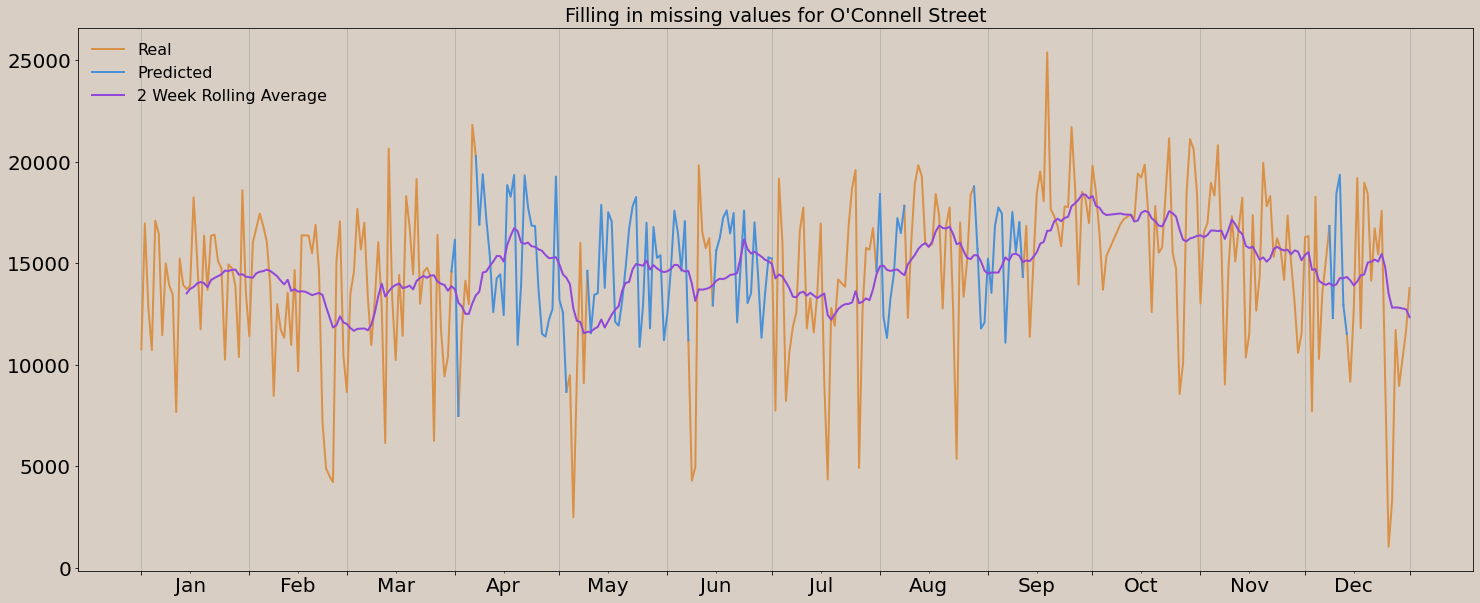

In [58]:
rolling = pred_peds.apply(lambda row: np.nansum([row.Predicted, row.Total_OConnell]), axis="columns").rolling(14).mean()

figure = plt.figure(figsize = (25, 10))
ax = plt.axes()
ax.xaxis.grid(True)
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title(label="Filling in missing values for O'Connell Street")
plt.plot(pred_peds["DoY"], pred_peds["Total_OConnell"], label="Real", color=O)
plt.plot(pred_peds["DoY"], pred_peds["Connectors"], label=None, color=FG)
plt.plot(pred_peds["DoY"], pred_peds["Predicted"], label="Predicted", color=FG)
plt.plot(pred_peds["DoY"], rolling, label="2 Week Rolling Average", color=V)
xticks = pred_peds.loc[(pred_peds["Day"]==1) | (pred_peds["DoY"]==365)]["DoY"].values
ax.xaxis.set_major_formatter(ticker.NullFormatter())
plt.xticks(ticks=xticks)
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks[:-1]+14))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(months[1:]))
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.legend(loc="upper left")
figure.savefig('res/fig/filling_missing_values.png')
plt.show()

In [59]:
pred_peds["Avg"] = np.nanmean(pred_peds[["Total_Capel", "Total_Henry", "Total_Mary", "Total_OConnell", "Predicted"]], axis=1)

In [60]:
pred_peds[["Predicted", "Total_OConnell", "Total_Henry", "Total_Mary", "Total_Capel"]].sample(1)

Predicted  Total_OConnell  Total_Henry  Total_Mary  Total_Capel
229        NaN         17320.0      45309.0        6508         6436

In [61]:
# Christmas has a total of 2,937 across all 4 streets
# far less is usual for even one street, keeping it in
# will just create an extremely long tail on the distribution,
# squasing the curves on the graph
no_christmas = pred_peds.loc[pred_peds["DoY"] != 359]
mon_sat = no_christmas.loc[no_christmas["DoW"] < 6]
sun = no_christmas.loc[no_christmas["DoW"] == 6]

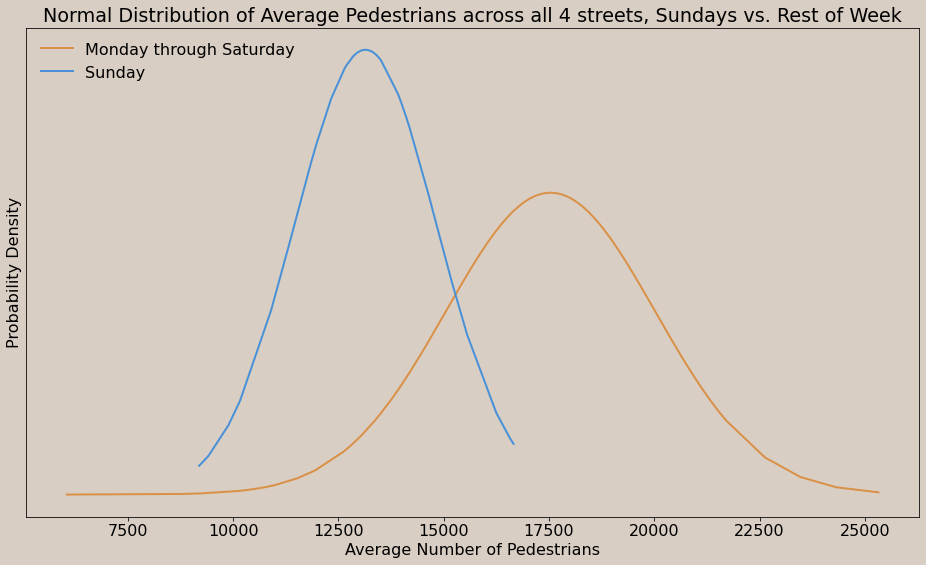

In [62]:
# The highest and lowest values for Sunday are considerable outliers
# excluding these two values produces as much more representative distribution
sun_avg = sun.sort_values("Avg")["Avg"].values[1:-1]
sun_pdf = norm.pdf(sun_avg, np.mean(sun_avg), np.std(sun_avg))
mon_sat_avg = mon_sat.sort_values("Avg")["Avg"].values
mon_sat_pdf = norm.pdf(mon_sat_avg, np.mean(mon_sat_avg), np.std(mon_sat_avg))

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title("Normal Distribution of Average Pedestrians across all 4 streets, Sundays vs. Rest of Week")
plt.plot(mon_sat_avg, mon_sat_pdf, label="Monday through Saturday ", color=O)
plt.plot(sun_avg, sun_pdf, label = "Sunday", color=FG)
plt.legend(loc='upper left')
plt.xlabel('Average Number of Pedestrians')
plt.ylabel('Probability Density')
plt.yticks([])
figure.savefig('res/fig/normal_dist_sun_vs_rest.png')
plt.show()

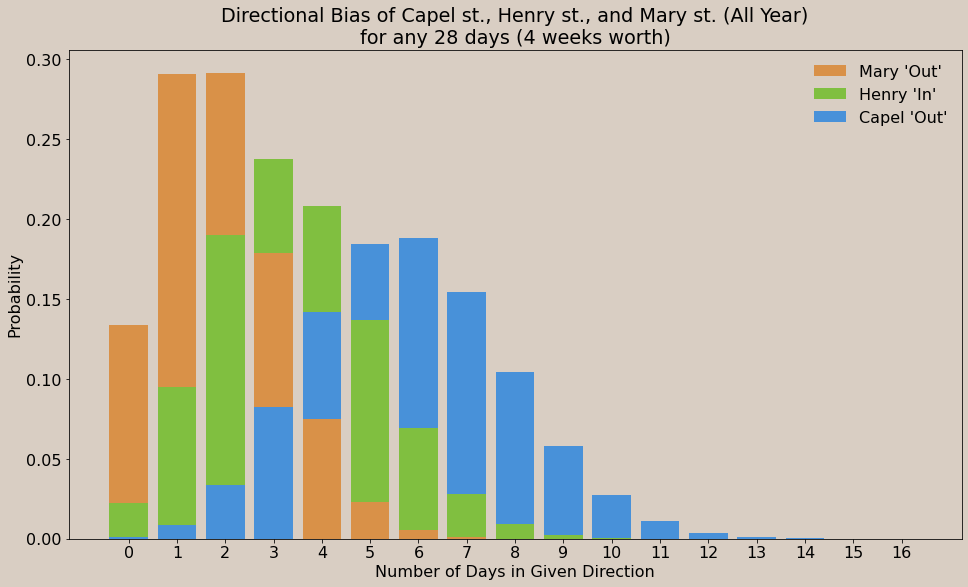

In [63]:
sample_size = 28
x = np.arange(0, sample_size+1)

def hgeo(street):
    num_days = pred_peds.shape[0]
    out = np.sum(pred_peds["Out_"+street] >= pred_peds["In_"+street])
    # Henry street is more predisposed towards the "Out" direction
    # whereas the other strets are biased towards the "In" direction
    # Since I only care about how biased a street is
    # inverting the direction will allow better comparison
    # since Henry Street won't be on the other side of the graph
    if out > num_days/2:
        out = num_days-out
    y = hypergeom(num_days, out, sample_size).pmf(x)
    return y

s = 17
x = x[:s]
capel = hgeo("Capel")[:s]
henry = hgeo("Henry")[:s]
mary = hgeo("Mary")[:s]
capel_highest = (capel > henry) & (capel > mary)
henry_highest = (henry > capel) & (henry > mary)
mary_highest = (mary > henry) & (mary > capel)
# if capel has the highest value then it's bottom should be the higher of mary and henry
# if it is not the highest then take the lower of the other two
# if capel is the lowest then the value from the previous steps will be zeroed out
capel_bottom = (capel_highest*np.fmax(henry, mary) + ~capel_highest*np.fmin(henry, mary)) * ~((capel < henry) & (capel < mary))
henry_bottom = (henry_highest*np.fmax(mary, capel) + ~henry_highest*np.fmin(mary, capel)) * ~((henry < mary) & (henry < capel))
mary_bottom = (mary_highest*np.fmax(capel, henry) + ~mary_highest*np.fmin(capel, henry)) * ~((mary < henry) & (mary < capel))

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title("Directional Bias of Capel st., Henry st., and Mary st. (All Year)\nfor any 28 days (4 weeks worth)")
plt.bar(x[:s], mary-mary_bottom, bottom=mary_bottom, label="Mary 'Out'", color=O)
plt.bar(x[:s], henry-henry_bottom, bottom=henry_bottom, label="Henry 'In'", color=L)
plt.bar(x[:s], capel-capel_bottom, bottom=capel_bottom, label="Capel 'Out'", color=A)
plt.legend(loc="upper right")
plt.xlabel("Number of Days in Given Direction")
plt.ylabel("Probability")
plt.xticks(x)
plt.yticks(np.arange(0, 0.35, 0.05))
figure.savefig('res/fig/hypergeometric_distribution_street_directions.png')
plt.show()

In [64]:
np.sum(pred_peds["Out_Mary"] >= pred_peds["In_Mary"])

24

In [65]:
pred_peds.loc[pred_peds["Out_Mary"] >= pred_peds["In_Mary"]]

Date  Total_Capel  In_Capel  Out_Capel  Total_Henry  In_Henry  \
1   2015-01-02         4437      2150       2287      48178.0   23862.0   
2   2015-01-03         5278      2819       2459      35378.0   17613.0   
3   2015-01-04         4098      2020       2078      29164.0   13832.0   
4   2015-01-05         5757      3162       2595      42606.0   20317.0   
5   2015-01-06         5642      3032       2610      42517.0   21070.0   
7   2015-01-08         4905      2477       2428      43231.0   21414.0   
13  2015-01-14         4936      2544       2392      38601.0   18721.0   
15  2015-01-16         5820      3012       2808      43952.0   21568.0   
16  2015-01-17         5844      3074       2770      43422.0   21321.0   
17  2015-01-18         4407      2158       2249      29925.0   15900.0   
18  2015-01-19         5596      2898       2698      40565.0   19509.0   
19  2015-01-20         5480      2769       2711      38633.0   18230.0   
20  2015-01-21         5687      2859       2828      41666.0   20695.0   
21  2015-01-22         6058      3094       2964      49172.0   23662.0   
23  2015-01-24         6288      3373       2915      45669.0   22315.0   
31  2015-02-01         4601      2403       2198      31705.0   15723.0   
33  2015-02-03         5796      3168       2628      42337.0   21058.0   
34  2015-02-04         5975      3172       2803      42325.0   20911.0   
35  2015-02-05         6286      3281       3005      46302.0   22667.0   
36  2015-02-06         5946      3000       2946      46967.0   22314.0   
37  2015-02-07         6648      3682       2966      44125.0   21658.0   
41  2015-02-11         5760      2861       2899      40060.0   19442.0   
44  2015-02-14         5974      3099       2875      45711.0   21012.0   
51  2015-02-21         5757      2965       2792      44606.0   22095.0   

    Out_Henry  Total_Mary  In_Mary  Out_Mary  Total_OConnell  DoY  DoW  Day  \
1     24316.0        7077     3339      3738         16964.0    2    4    2   
2     17765.0        6139     2786      3353         12856.0    3    5    3   
3     15332.0        5322     2323      2999         10722.0    4    6    4   
4     22289.0        6670     3133      3537         17099.0    5    0    5   
5     21447.0        6168     2992      3176         16441.0    6    1    6   
7     21817.0        5917     2873      3044         14995.0    8    3    8   
13    19880.0        5048     2442      2606         13729.0   14    2   14   
15    22384.0        6350     3089      3261         18247.0   16    4   16   
16    22101.0        7199     3438      3761         15266.0   17    5   17   
17    14025.0        5368     2361      3007         11743.0   18    6   18   
18    21056.0        6345     2924      3421         16363.0   19    0   19   
19    20403.0        5279     2486      2793         13692.0   20    1   20   
20    20971.0        5925     2834      3091         16359.0   21    2   21   
21    25510.0        7013     3262      3751         16411.0   22    3   22   
23    23354.0        7777     3633      4144         14747.0   24    5   24   
31    15982.0        5372     2527      2845         11400.0   32    6    1   
33    21279.0        6002     2929      3073         16731.0   34    1    3   
34    21414.0        6521     3020      3501         17446.0   35    2    4   
35    23635.0        6978     3269      3709         16825.0   36    3    5   
36    24653.0        6214     2924      3290         16070.0   37    4    6   
37    22467.0        6590     3291      3299         13909.0   38    5    7   
41    20618.0        5922     2925      2997         11326.0   42    2   11   
44    24699.0        7622     3705      3917         14663.0   45    5   14   
51    22511.0        7049     3485      3564         14591.0   52    5   21   

    Month  Label  Predicted  Connectors       Avg  
1       1     -1        NaN         NaN  19164.00  
2       1     -1        NaN         NaN  14912.75  
3 

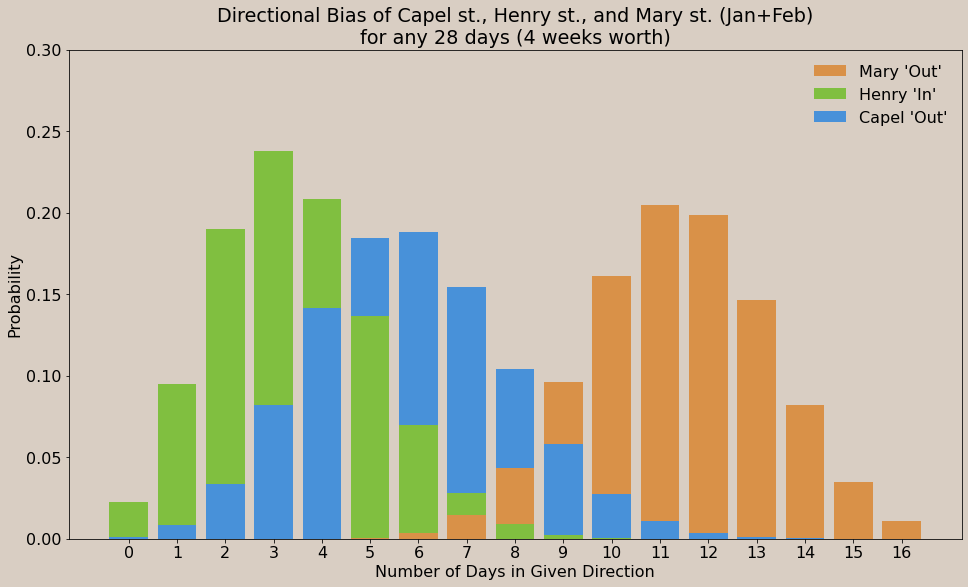

In [66]:
sample_size = 28
x = np.arange(0, sample_size+1)

mary_reduced = pred_peds.loc[pred_peds["Month"] < 3]
num_days = mary_reduced.shape[0]
out = np.sum(mary_reduced["Out_Mary"] >= mary_reduced["In_Mary"])
mary = hypergeom(num_days, out, sample_size).pmf(x)[:s]
x = x[:s]
capel_highest = (capel > henry) & (capel > mary)
henry_highest = (henry > capel) & (henry > mary)
mary_highest = (mary > henry) & (mary > capel)
capel_bottom = (capel_highest*np.fmax(henry, mary) + ~capel_highest*np.fmin(henry, mary)) * ~((capel < henry) & (capel < mary))
henry_bottom = (henry_highest*np.fmax(mary, capel) + ~henry_highest*np.fmin(mary, capel)) * ~((henry < mary) & (henry < capel))
mary_bottom = (mary_highest*np.fmax(capel, henry) + ~mary_highest*np.fmin(capel, henry)) * ~((mary < henry) & (mary < capel))

figure = plt.figure(figsize = (16, 9))
ax = plt.axes()
ax.set_facecolor(BG)
figure.patch.set_facecolor(BG)
plt.title("Directional Bias of Capel st., Henry st., and Mary st. (Jan+Feb)\nfor any 28 days (4 weeks worth)")
plt.bar(x[:s], mary-mary_bottom, bottom=mary_bottom, label="Mary 'Out'", color=O)
plt.bar(x[:s], henry-henry_bottom, bottom=henry_bottom, label="Henry 'In'", color=L)
plt.bar(x[:s], capel-capel_bottom, bottom=capel_bottom, label="Capel 'Out'", color=A)
plt.legend(loc="upper right")
plt.xlabel("Number of Days in Given Direction")
plt.ylabel("Probability")
plt.xticks(x)
plt.yticks(np.arange(0, 0.35, 0.05))
figure.savefig('res/fig/hypergeometric_distribution_street_directions_mary_reduced.png')
plt.show()